In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
from zipfile import ZipFile


os.makedirs('data', exist_ok=True)
os.chdir('..')
source_path = "content/drive/Othercomputers/My Laptop/RP/data/CSCD.zip"
destination_path = "content/data/CSCD.zip"

shutil.copy(source_path, destination_path)

with ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall("content/data")

print("File copied and unpacked successfully.")

File copied and unpacked successfully.


In [3]:
os.chdir(os.path.join("content", "drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
# os.chdir(os.path.join("..", "..", "..", "..", "..", ".."))
# os.makedirs('data', exist_ok=True)

In [4]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 67.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cac

#### Imports


In [27]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import train_test
import cscd_dataset_loader
reload(cscd_dataset_loader)
from levir_dataset_loader import LEVIR_Dataset
from hrscd_dataset_loader import HRSCD_Dataset
from cscd_dataset_loader import CSCD_Dataset
from late_siam_net import SiamLateFusion
import time


#### Load Data

In [28]:
N_EPOCHS = 10
FP_MODIFIER = 1
BATCH_SIZE = 16
PATCH_SIZE = 1024
STRIDE = 50
TEST_RUN = False
RELATIVE_TO_CSCD = os.path.join('..', '..', '..',  '..', '..')
# DIRNAME_CSCD = os.path.join(RELATIVE_TO_CSCD, "data")
DIRNAME_CSCD = os.path.join(RELATIVE_TO_CSCD, "data", "CSCD")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# train_dataset_levir = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
# test_dataset_levir = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
# val_dataset_levir  = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

# train_dataset_hrscd = HRSCD_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)
# test_dataset_hrscd = HRSCD_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
# val_dataset_hrscd = HRSCD_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)

train_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "train", STRIDE, PATCH_SIZE)
test_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "test", STRIDE, PATCH_SIZE)
val_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "val", STRIDE, PATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.FloatTensor(train_dataset_cscd.weights).to(device)
print(weights)

tensor([ 76.6695, -74.6695], device='cuda:0')


In [30]:
train_loader = DataLoader(train_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
val_loader = DataLoader(val_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

# net, net_name = Unet(3, 2), 'Early-Fusion'
net, net_name = SiamUnet_conc(3, 2), 'Mid-Conc-Fusion'
# net, net_name = SiamUnet_diff(3, 2), 'Mid-Diff-Fusion'
# net, net_name = SiamLateFusion(3, 2), 'Late-Fusion'
net.to(device)

criterion = nn.NLLLoss(weight=weights)
# criterion = nn.CrossEntropyLoss(weight=weights)

In [31]:
import gc
torch.cuda.empty_cache()
gc.collect()

119633

In [32]:
from train_test import train

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset_cscd, train_loader, val_dataset_cscd, criterion, PATCH_SIZE, device, n_epochs=15, save=True, save_dir = save_dir)

100%|██████████| 16/16 [00:00<00:00, 29.37it/s]
/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:43: RuntimeWarning: invalid value encountered in divide
  cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
100%|██████████| 16/16 [00:00<00:00, 32.67it/s]
/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:41: RuntimeWarning: invalid value encountered in divide
  predicted = (predicted - np.min(predicted)) / (np.max(predicted) - np.min(predicted))
100%|██████████| 16/16 [00:00<00:00, 29.90it/s]


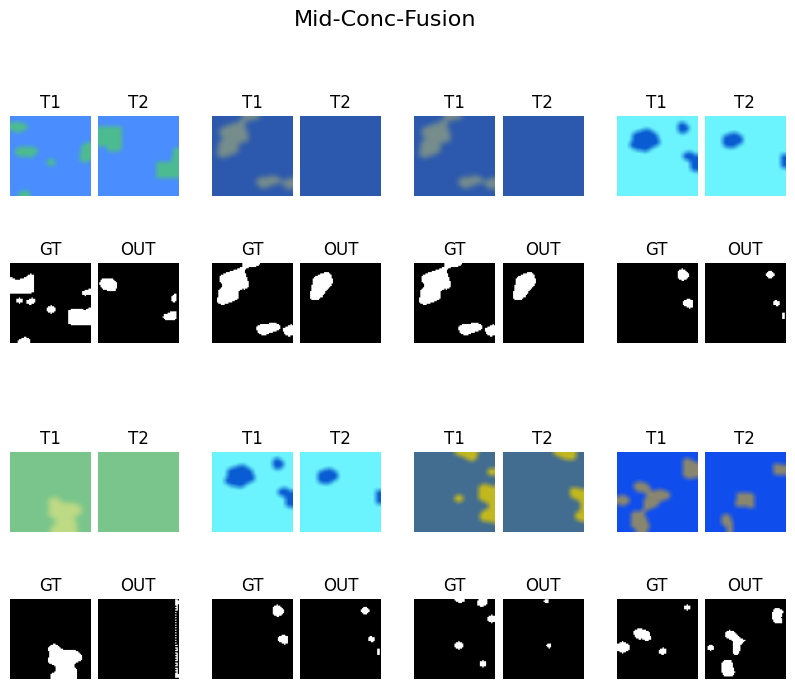

In [33]:
from data_examination import examine_subset

examine_subset(net, net_name, test_dataset_cscd, 10, device)

In [34]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset_cscd, PATCH_SIZE)

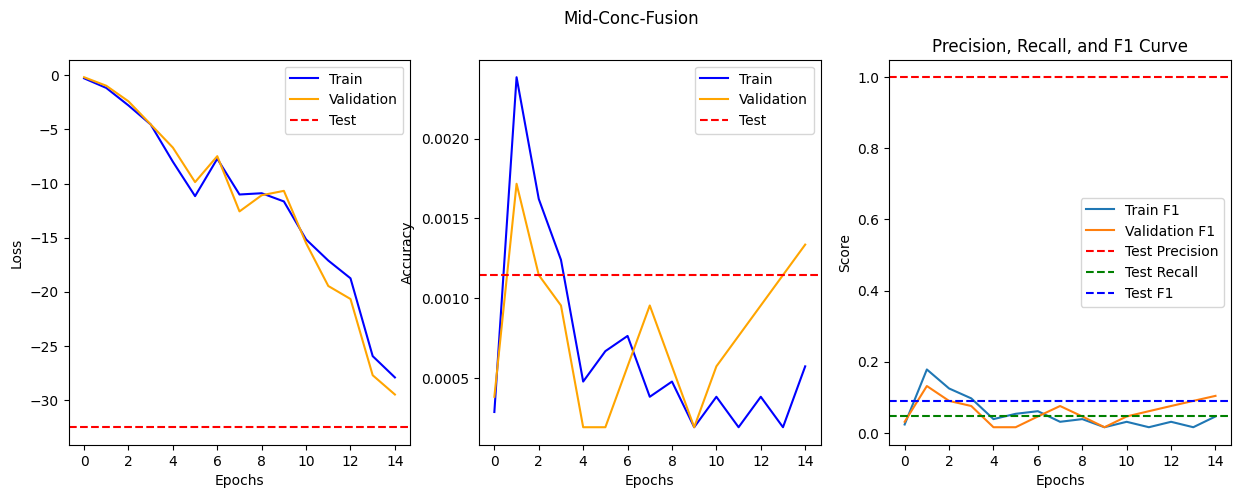

In [35]:
from tables import create_tables
from plots import create_figures


create_figures(training_metrics, test_metrics, net_name)
create_tables(training_metrics, test_metrics, net_name)

In [36]:
reload(metrics)
from metrics import evaluate_categories



categorical_metrics = evaluate_categories(net, "CSCD", test_dataset_cscd, ["large_change_uniform", "large_change_non_uniform", "small_change_non_uniform", "small_change_uniform"])
# categorical_metrics = evaluate_categories(net, test_dataset, ["No info", "Artificial surfaces", "Agricultural Surfaces" "Forests", "Wetlands", "Water"], 1000)

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:191: RuntimeWarning: invalid value encountered in divide
  predicted = (predicted - np.min(predicted)) / (np.max(predicted) - np.min(predicted))


In [37]:
categorical_metrics

{'large_change_uniform': array([  0,   0,  21, 107]),
 'large_change_non_uniform': array([10,  0, 97, 21]),
 'small_change_non_uniform': array([ 8,  0, 98, 22]),
 'small_change_uniform': array([  4,   0, 100,  24])}

{'large_change_uniform': array([  0,   0,  21, 107]), 'large_change_non_uniform': array([10,  0, 97, 21]), 'small_change_non_uniform': array([ 8,  0, 98, 22]), 'small_change_uniform': array([  4,   0, 100,  24])}


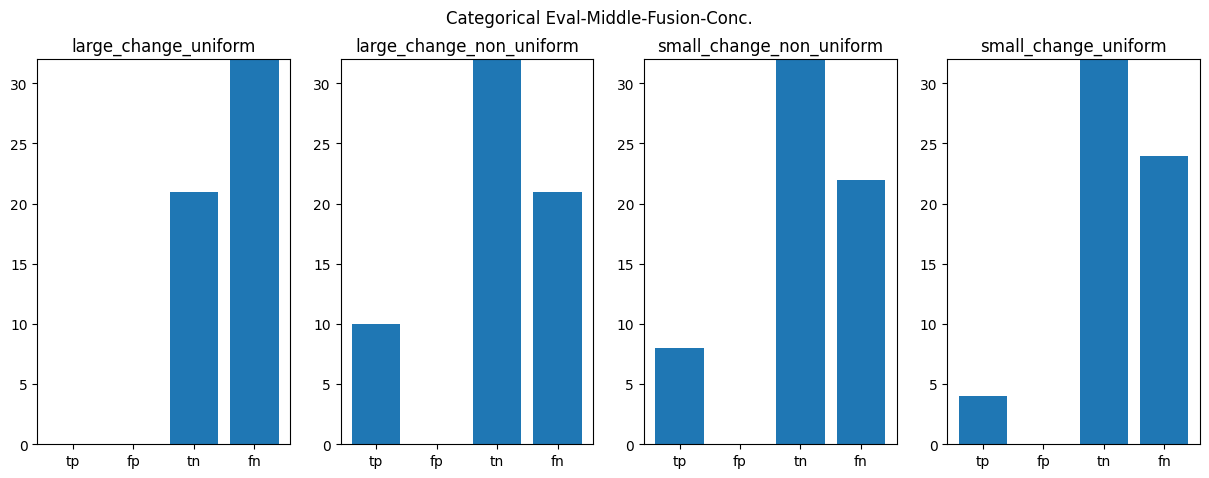

In [38]:
# from plots import category_histograms

category_histograms('Middle-Fusion-Conc.', 'Categorical Eval', categorical_metrics )

In [ ]:
import torch
from torch.autograd import Variable
from tqdm import tqdm as tqdm
import numpy as np
from math import ceil
import cv2


def evaluate_net_predictions(net, criterion, dataset, patch_size):
    net.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    tot_loss = 0
    tot_count = 0

    for img_index in dataset.names:
        I1, I2, cm, _ = dataset.get_img(img_index)

        cm = cm.astype(float) / 255
        I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
        I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))

        output = net(I1, I2).float().to(device)

        loss = criterion(output, cm)
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        _, predicted = torch.max(output.data, 1)

        predicted = np.squeeze(output.cpu().detach().numpy())[0] -np.squeeze(output.cpu().detach().numpy())[1]
        predicted = (predicted - np.min(predicted)) / (np.max(predicted) - np.min(predicted))
        cm = np.squeeze(cm.cpu().detach().numpy())
        cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
        predicted = np.where(predicted < 0.5, 0, 1)
        cm = np.where(cm < 0.5, 0, 1)

        pr = np.where(predicted > 0.5 , 1, 0)
        gt = np.where(cm > 0.5, 1, 0)

        # pr = (predicted.int() > 0).cpu().numpy()
        # gt = (cm.data.int() > 0).cpu().numpy()

        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count


    prec = tp / max(1, (tp + fp))
    rec = tp / max(1, (tp + fn))


    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'precision': prec,
            'recall': rec}

def cluster_image_colors(img, categories):
    Z = img.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = len(categories)
    _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    out = res.reshape((img.shape))

    return out

def map_to_categorical(img):
    vals = np.sort(np.unique(img))

    value_to_position = {value: index for index, value in enumerate(vals)}

    # Assumes img is one dimensional
    positions = np.vectorize(value_to_position.get)(np.ndarray.flatten(img))

    return positions.reshape(img.shape)


def evaluate_img_categorically(y, y_hat, y_category, categories):


    out = {c: [0, 0, 0, 0] for c in categories}
    y_category = y_category[:, :, 0].astype(int)

    white_pixels_gt = np.sum((y == 1))
    black_pixels_gt = np.sum((y == 0))


    for c in categories:
        mask = y_category == categories.index(c)  # Create a mask for the current category

        tp_pixel = np.sum((y == 1) & (y_hat == 1) & mask)
        fp_pixel = np.sum((y == 1) & (y_hat == 0) & mask)
        tn_pixel = np.sum((y == 0) & (y_hat == 0) & mask)
        fn_pixel = np.sum((y == 0) & (y_hat == 1) & mask)


        index = iou_criterion(tp_pixel, fp_pixel, tn_pixel, fn_pixel)
        out[c][index] = 1


    return out




def evaluate_categories(net, dataset_name, dataset, categories):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    categorical_metrics = {}

    for c in categories:
        categorical_metrics[c] = [0, 0, 0, 0] #tp, fp, tn,  fn

    index = 0

    for img_index in dataset.names:
        index += 1

        if dataset_name == "CSCD":
            I1, I2, cm, situation = dataset.get_img(img_index)
            categorical = np.divide(cv2.cvtColor(cm, cv2.COLOR_GRAY2RGB), 255)
            categorical = np.multiply(categorical, categories.index(situation))

        elif dataset_name in ["HRSCD", "HIUCD"]:
            I1, I2, cm, categorical = dataset.get_img(img_index)
            categorical = cluster_image_colors(categorical, categories)

            categorical = map_to_categorical(categorical)
        else:
            print('Not a categorical dataset')
            break


        I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
        I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))

        cm = cm.astype(float) / 255
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))


        output = net(I1, I2).float().to(device)

        _, predicted = torch.max(output.data, 1)


        predicted = np.squeeze(output.cpu().detach().numpy())[0] -np.squeeze(output.cpu().detach().numpy())[1]
        predicted = (predicted - np.min(predicted)) / (np.max(predicted) - np.min(predicted))
        cm = np.squeeze(cm.cpu().detach().numpy())
        cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
        predicted = np.where(predicted < 0.5, 0, 1)
        cm = np.where(cm < 0.5, 0, 1)

        curr_metrics = evaluate_img_categorically(cm, predicted, categorical, categories)

        for c in categories:
            categorical_metrics[c] = np.add(categorical_metrics[c], curr_metrics[c])



    return categorical_metrics

